In [1]:
import glob
import pickle
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
from alive_progress import alive_bar


In [2]:
traj_id = 50
file_name = glob.glob(str(Path("bingo") / f"*traj_{traj_id}*"))
print(file_name)
assert len(file_name) == 1

with open(file_name[0], "rb") as f:
    all_tokens = pickle.load(f)
print(f"Number of tokens: {len(all_tokens)}")
print(f"Number of timesteps: {len(all_tokens) / (32*32)}")

['bingo/activations_traj_50.pkl']
Number of tokens: 109568
Number of timesteps: 107.0


In [3]:
# create a histogram of all the dEdT values
dEdT = []
activations = []
features = []
token_ids = []
with alive_bar(len(all_tokens), force_tty=True) as bar:
    for token_id, token_value in all_tokens.items():
        dEdT.extend(token_value["dEdT"])
        activations.extend(token_value["activations"])
        features.extend(token_value["features"])
        token_ids.extend([token_id]*len(token_value["dEdT"]))
        bar()
dEdT = np.array(dEdT)
activations = np.array(activations)
features = np.array(features)
token_ids = np.array(token_ids)


|████████████████████████████████████████| 109568/109568 [100%] in 0.8s (133423.


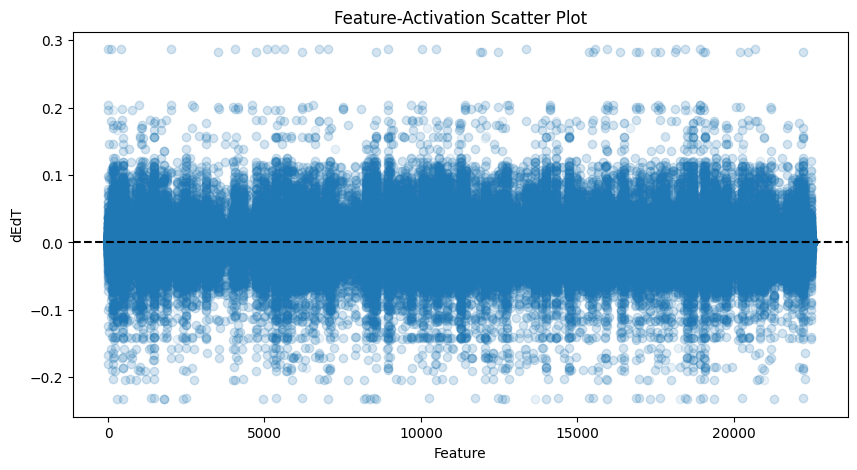

In [4]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(features, dEdT, alpha=0.1)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Feature")
plt.ylabel("dEdT")
plt.title("Feature-Activation Scatter Plot")
plt.show()


In [24]:
features.max()
print(2816*8)

22528


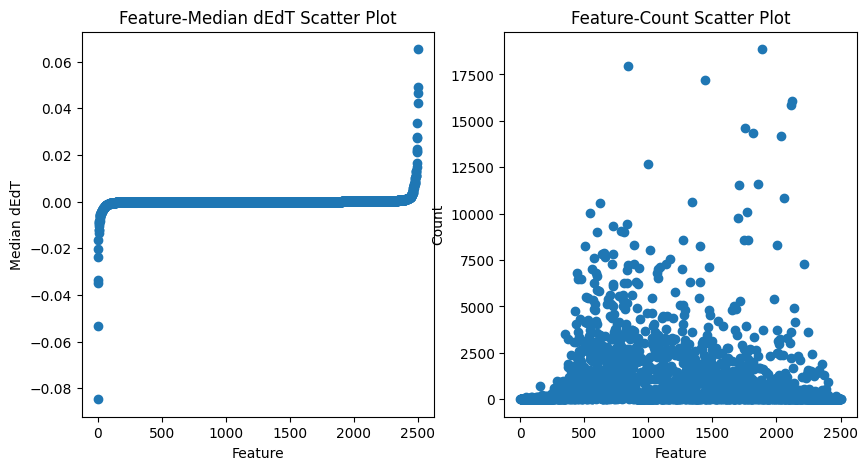

In [9]:
unique_features = np.unique(features)
median_dEdT = np.zeros(len(unique_features))
feature_cnts = np.zeros(len(unique_features))
for i, feature in enumerate(unique_features):
    mask = (features == feature)
    median_dEdT[i] = np.median(np.array(dEdT)[mask])
    feature_cnts[i] = np.sum(mask)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sort_me = np.argsort(median_dEdT)
# sorted_median_dEdT  = np.sort(median_dEdT)
# plt.scatter(unique_features, median_dEdT, alpha=0.1)
axes[0].plot(median_dEdT[sort_me], 'o')
axes[0].set_ylabel("Median dEdT")
axes[0].set_xlabel("Feature")
axes[0].set_title("Feature-Median dEdT Scatter Plot")
axes[1].plot(feature_cnts[sort_me], 'o')
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Feature")
axes[1].set_title("Feature-Count Scatter Plot")
plt.show()

# Sort by increading dEdT
sorted_unique_features = unique_features[sort_me]



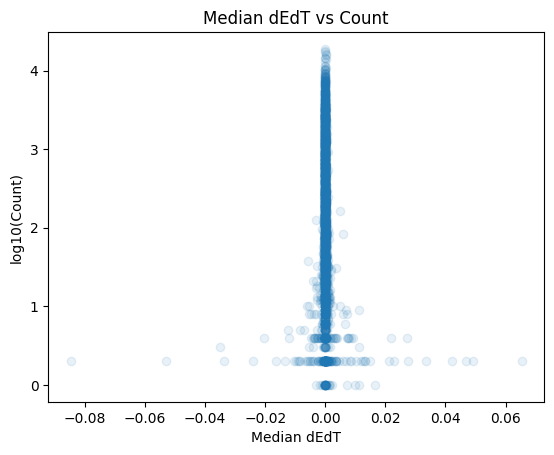

In [11]:
plt.scatter(median_dEdT, np.log10(feature_cnts), alpha=0.1)
plt.xlabel("Median dEdT")
plt.ylabel("log10(Count)")
plt.title("Median dEdT vs Count")
plt.show()



0

(2150400,) (2150400,) (2150400,)


ValueError: cannot reshape array of size 20480 into shape (32,32)

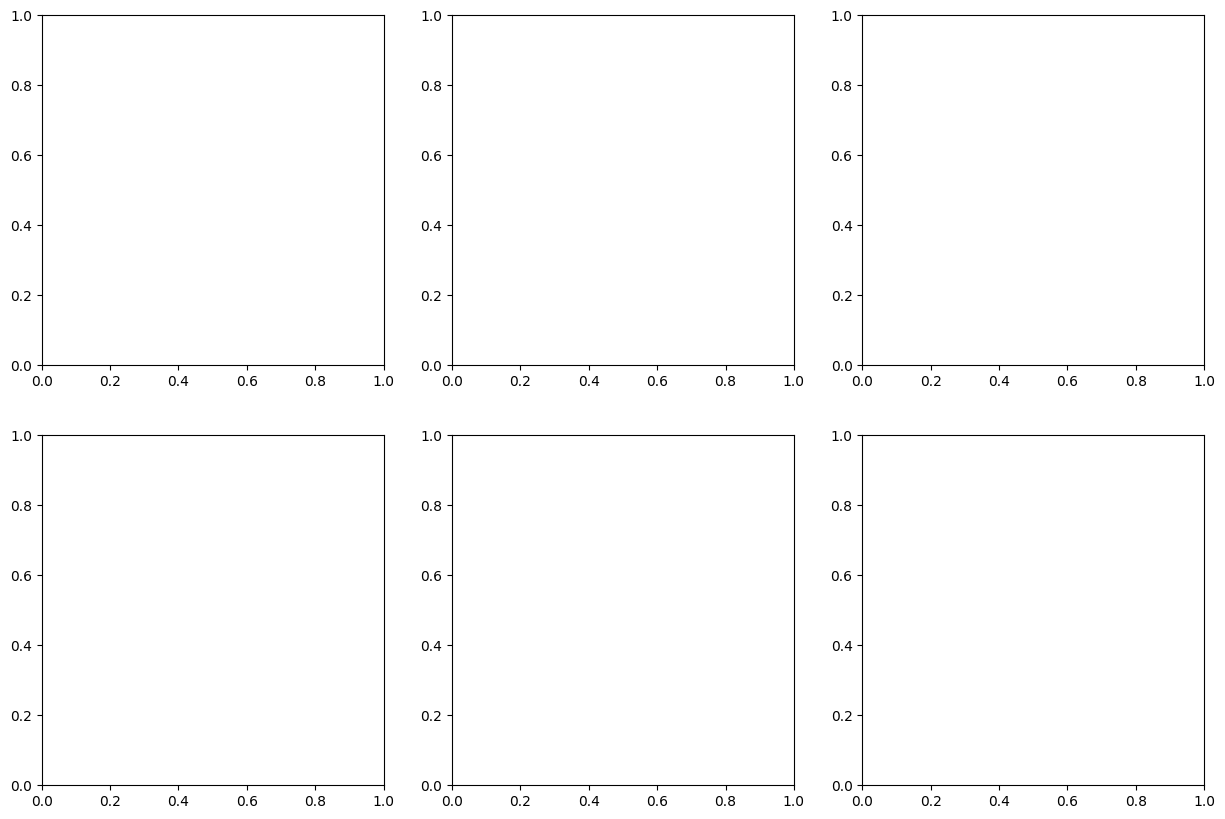

In [ ]:
max_t = int(len(all_tokens) / (32*32)) # maximum T considered
t,x,y = np.unravel_index(token_ids, (max_t, 32, 32))
print(t.shape, x.shape, y.shape)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
i = 0
for t_snap in range(max_t):
    mask = t == t_snap
    if np.sum(mask) == 0:
        continue
    dEdT_snap = dEdT[mask]
    index_snap = np.ravel_multi_index((x[mask], y[mask]), (32, 32))
    dEdT_snap = dEdT_snap[np.argsort(index_snap)].reshape(32, 32)
    axes[i//3, i%3].imshow(dEdT_snap)
    axes[i//3, i%3].set_title(f"Time {i}")
    if i == 6:
        break
    i += 1
plt.show()


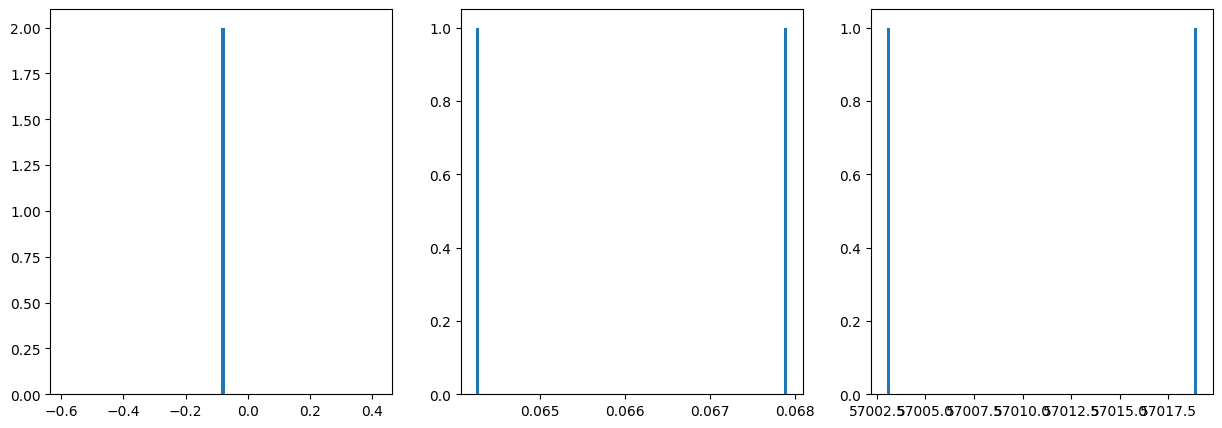

Feature: 9223


In [ ]:
feature = sorted_unique_features[0]

mask = features == feature
feature_token_ids = token_ids[mask]
feature_activations = activations[mask]
feature_dEdT = dEdT[mask]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(feature_dEdT, bins=100)
axes[1].hist(feature_activations, bins=100)
axes[2].hist(feature_token_ids, bins=100)
plt.show()

print(f"Feature: {feature}")



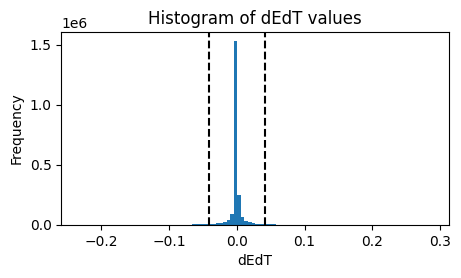

In [7]:
fig = plt.figure(figsize=(5, 2.5))
plt.hist(dEdT, bins=100);
for p in [1, 99]:
    plt.axvline(np.percentile(dEdT, p), color="k", linestyle="--")
plt.xlabel("dEdT")
plt.ylabel("Frequency")
plt.title("Histogram of dEdT values")
plt.show()


In [8]:
for p, lt in zip([1, 99], ['lt', 'gt']):
    dEdT_p = np.percentile(dEdT, p)
    if lt == 'lt':
        mask = np.array(dEdT) < dEdT_p
    else:
        mask = np.array(dEdT) > dEdT_p
    activations_p = np.array(activations)[mask]
    features_p = np.array(features)[mask]
    print(f"Number of features in {p} percentile: {len(activations_p)} / {len(activations)}")


Number of features in 1 percentile: 21480 / 2150400
Number of features in 99 percentile: 21480 / 2150400
